In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2021-09-27 22:20:06.363722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 22:20:06.479156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 22:20:06.480057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 22:20:06.481571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1885] Ignoring visible gpu device (device: 0, name: GeForce GTX 560M, pci bus id: 0000:01:00.0, compute capability: 2.1) with Cuda compute capability 2.1. The minimum required Cuda capability is 3.5.


In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [4]:
from tensorflow.keras.utils import to_categorical

In [3]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [4]:
np.shape(df_test)

(41088, 82)

In [5]:
np.shape(df)
# 844338, 108

(844338, 83)

In [8]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

#cat_vars = ['Store', 'DayOfWeek', 'Month', 'Promo2Weeks']
#cat_vars = ['Store', 'DayOfWeek', 'Month']

In [10]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
contin_vars = ['BeforeStateHoliday_bool', 'Max_TemperatureC']

In [11]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [12]:
uniques.T

,uniques
Store,1115
DayOfWeek,7
Month,12


# Asignación de dimensión de embeddings

In [13]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Month': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [14]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   1    2    3 ... 1113 1114 1115]

DayOfWeek 2 7 [1 2 3 4 5 6 7]

Month 2 12 [ 1  2  3  4  5  6  7  8  9 10 11 12]



# Definición de modelo

In [16]:
add_customers = True
log_output = True
output_activation = 'linear'

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [73]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0] + 1, cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [74]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [75]:
# Descomentar para ver resultados
cat_vars_embed_outs
cat_var_inputs


[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Store_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'DayOfWeek_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Month_input')>]

In [81]:
cont_vars_inputs
cont_vars_outs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BeforeStateHoliday_bool_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Max_TemperatureC_input')>]

In [76]:
first_hidden_units = 1000
second_hidden_units = 500
l2_lambda = 1e-3
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = LeakyReLU()(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = LeakyReLU()(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [77]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [78]:
# Descomentar para ver
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Store_Embed (Embedding)         (None, 1, 50)        55800       Store_input[0][0]                
____________________________________________________________________________________________

In [79]:
model.save_weights('initial_weights.hdf5')

In [80]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [81]:

np.shape(df_val)

(30188, 83)

In [38]:
np.shape(df_train)

(814150, 83)

In [40]:
# ventas normalizadas por tienda en el transcurso del tiempo Date.

from matplotlib import pyplot as plt
# plt.figure(figsize=(20,5))
# plt.plot((df_train[df_train['Store']==1]['Sales'].values - df_train[df_train['Store']==1]['Sales'].mean())/df_train[df_train['Store']==1]['Sales'].std())
# plt.show()
# plt.figure(figsize=(20,5))
# plt.plot(np.log(df_train[df_train['Store']==1]['Sales'].values)/np.max(np.log(df_train[df_train['Store']==1]['Sales'].values)))
# plt.show()

In [42]:
df_train

,level_0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,BeforeStateHoliday_bool,AfterPromo,BeforePromo,index,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
30188,34565,1,2,2015-06-30,5735,568,1,1,0,0,...,0,0,0,910,0.0,0.0,2.0,0.0,0.0,4.0
30189,34566,2,2,2015-06-30,9863,877,1,1,0,0,...,0,0,0,1852,0.0,0.0,2.0,0.0,0.0,4.0
30190,34567,3,2,2015-06-30,13261,1072,1,1,0,1,...,0,0,0,2794,2.0,0.0,2.0,5.0,0.0,4.0
30191,34568,4,2,2015-06-30,13106,1488,1,1,0,0,...,0,0,0,3736,0.0,0.0,2.0,0.0,0.0,4.0
30192,34569,5,2,2015-06-30,6635,645,1,1,0,0,...,0,0,0,4678,0.0,0.0,2.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,1016776,682,2,2013-01-01,3375,566,1,0,a,1,...,0,0,-6,620526,1.0,1.0,0.0,4.0,1.0,1.0
844334,1016827,733,2,2013-01-01,10765,2377,1,0,a,1,...,0,0,-6,666728,1.0,1.0,0.0,4.0,1.0,1.0
844335,1016863,769,2,2013-01-01,5035,1248,1,0,a,1,...,0,0,-6,699720,1.0,1.0,0.0,4.0,1.0,1.0
844336,1017042,948,2,2013-01-01,4491,1039,1,0,a,1,...,0,0,-6,863186,1.0,1.0,0.0,4.0,2.0,1.0


In [82]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [83]:
len(stores_mean)

1115

In [84]:
df_train['Store'].head()

30188    1
30189    2
30190    3
30191    4
30192    5
Name: Store, dtype: int64

In [54]:
print(stores_mean.get(1))

4768.684350132626


In [85]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

/home/j3nnn1/anaconda3/envs/roosmanProject/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [86]:
df_train.loc[:, ['Store','mean_by_store']]

,Store,mean_by_store
30188,1,4768.684350
30189,2,4953.887715
30190,3,6947.773936
30191,4,9616.343461
30192,5,4679.026596
...,...,...
844333,682,11202.916575
844334,733,14945.514819
844335,769,10782.140505
844336,948,6888.931920


In [87]:
df_train.loc[:, ['Store','Sales_store']]

,Store,Sales_store
30188,1,966.315650
30189,2,4909.112285
30190,3,6313.226064
30191,4,3489.656539
30192,5,1955.973404
...,...,...
844333,682,-7827.916575
844334,733,-4180.514819
844335,769,-5747.140505
844336,948,-2397.931920


In [88]:
from tensorflow.keras import backend as K

In [89]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [90]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [91]:
get_metric(df_val, df_val['mean_by_store'])
# github OUT:  0.0943562401279468
# local : 0.3071746085338871
# colab: 0.30717460853388645

0.3071746085338871

In [65]:
np.shape(df_test)

(41088, 82)

In [92]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [93]:
print(all_vars)
print("")

print("all vars: ", len(all_vars))
print("categoricas vars: ", len(cat_vars))
print("continuas vars: ", len(contin_vars))

print("")
print("X_val shape: ", np.shape(X_val))
print("X_train shape: ", np.shape(X_train))
print("X_test shape: ", np.shape(X_test))

print("")
print("df_train[all_vars].shape" , df_train[all_vars].shape)


['Store', 'DayOfWeek', 'Month', 'BeforeStateHoliday_bool', 'Max_TemperatureC']

all vars:  5
categoricas vars:  3
continuas vars:  2

X_val shape:  (5, 30188, 1)
X_train shape:  (5, 814150, 1)
X_test shape:  (5, 41088, 1)

df_train[all_vars].shape (814150, 5)


In [94]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']

print("")
print("add_customers - y_out_columns:", y_out_columns)
print("")

if log_output:
    print("transforming to logarithm output: ")
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
#   print("transforming to normal output( X - mean/std")
#   y_train = (df_train[y_out_columns].values - y_mean)/y_std
#   y_val = (df_val[y_out_columns].values - y_mean)/y_std
    print("transforming to normal output( X / max)")
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max

print("")
print("hsplit: y_train - y_val", y_train.shape, y_val.shape)    
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])


add_customers - y_out_columns: ['Sales', 'Customers']

transforming to logarithm output: 

hsplit: y_train - y_val (814150, 2) (30188, 2)


In [95]:
print("after hsplit: y_train - y_val")
print(np.shape(y_train))
print(np.shape(y_val))

after hsplit: y_train - y_val
(2, 814150, 1)
(2, 30188, 1)


In [96]:
lr = 0.001
model.compile(optimizer=Adam(learning_rate=lr), metrics=['mse', rmspe], loss='mse')

In [97]:
add_customers = True
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [98]:
print(type(checkpoint))


<class 'keras.callbacks.ModelCheckpoint'>


In [108]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_val))
print(np.shape(y_val))

(5, 814150, 1)
(2, 814150, 1)
(5, 30188, 1)
(2, 30188, 1)


In [99]:
epochs = 20
batch_size = 256
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=2)

Epoch 1/20
3181/3181 - 56s - loss: 0.1379 - Sales_loss: 0.0163 - Customers_loss: 0.0261 - Sales_mse: 0.0163 - Sales_rmspe: 0.0679 - Customers_mse: 0.0261 - Customers_rmspe: 0.0744 - val_loss: 0.0426 - val_Sales_loss: 8.9391e-04 - val_Customers_loss: 6.5682e-04 - val_Sales_mse: 8.9391e-04 - val_Sales_rmspe: 0.0348 - val_Customers_mse: 6.5682e-04 - val_Customers_rmspe: 0.0339

Epoch 00001: val_Sales_mse improved from inf to 0.00089, saving model to bestmodel.hdf5
Epoch 2/20
3181/3181 - 57s - loss: 0.0207 - Sales_loss: 0.0010 - Customers_loss: 9.4521e-04 - Sales_mse: 0.0010 - Sales_rmspe: 0.0374 - Customers_mse: 9.4521e-04 - Customers_rmspe: 0.0412 - val_loss: 0.0061 - val_Sales_loss: 5.0065e-04 - val_Customers_loss: 4.9677e-04 - val_Sales_mse: 5.0065e-04 - val_Sales_rmspe: 0.0268 - val_Customers_mse: 4.9677e-04 - val_Customers_rmspe: 0.0297

Epoch 00002: val_Sales_mse improved from 0.00089 to 0.00050, saving model to bestmodel.hdf5
Epoch 3/20
3181/3181 - 57s - loss: 0.0030 - Sales_loss: 

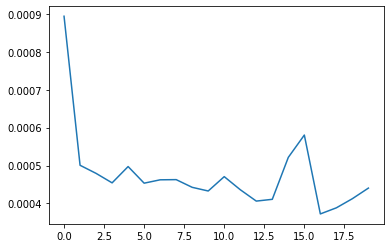

In [100]:
#plt.plot(history.history['val_loss'])
#plt.plot(history.history['val_Customers_mse'])
plt.plot(history.history['val_Sales_mse'])
plt.show()
# plt.plot(history.history['loss'])
# plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [101]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 3s 3ms/step - loss: 9.9832e-04 - Sales_loss: 4.4046e-04 - Customers_loss: 4.9865e-04 - Sales_mse: 4.4046e-04 - Sales_rmspe: 0.0240 - Customers_mse: 4.9865e-04 - Customers_rmspe: 0.0294

[0.000998317264020443,
 0.00044045865070074797,
 0.0004986549029126763,
 0.00044045865070074797,
 0.02398683875799179,
 0.0004986549029126763,
 0.029428841546177864]

In [102]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 3s 3ms/step - loss: 7.8880e-04 - Sales_loss: 3.7231e-04 - Customers_loss: 3.4741e-04 - Sales_mse: 3.7231e-04 - Sales_rmspe: 0.0229 - Customers_mse: 3.4741e-04 - Customers_rmspe: 0.0249

[0.0007888010004535317,
 0.0003723115078173578,
 0.0003474086115602404,
 0.0003723115078173578,
 0.02293321304023266,
 0.0003474086115602404,
 0.024851927533745766]

In [113]:
# model.load_weights('bestmodel.hdf5')
# model.evaluate(X_val, y_val)
# 30188/30188 [==============================] - 5s 172us/step
# [0.12197033089921382,
#  0.07211007360268763,
#  0.037183713050426136,
#  0.07211007360268763,
#  0.037183713050426136]

# [0.12932546436786652,
#  0.07751645147800446,
#  0.039259567856788635,
#  0.07751645147800446,
#  0.039259567856788635]

In [103]:
#log_output = False
#add_customers = True
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
        #print(type(X_val))
        print("X_val - variables: ", len(X_val))
        print("X_val - filas: ", len(X_val[0]))
        #print(type(X_val[3]))
        #print(X_val[:,0])
        #mp_tmp = model.predict(X_val, verbose=1)
        #print(len(mp_tmp))
        #print(type(mp_tmp))
        #print(type(mp_tmp[0]))
        #print(len(mp_tmp[0]))
        #print(mp_tmp[0:0])
        #print(mp_tmp[0])
        #print(mp_tmp[0][0])
        #y_pred = mp_tmp[:,0]*y_std + y_mean
        #y_pred = mp_tmp[0]*y_std + y_mean
        #print(y_pred[0][0])
        #y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        #y_pred_test = model.predict(X_test, verbose=1)[0]*y_std + y_mean
        #y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        #y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
        # print(type(y_pred))
        # print(y_pred.shape)
        # print(type(y_max))
        # print(y_max.shape)
        #y_pred = model.predict(X_val, verbose=1)[0]*y_max
        #y_pred = model.predict(X_val, verbose=1)[0]
        print("")
        print("model.predict: X_val")
        y_pred = model.predict(X_val, verbose=1) *y_max
        print("output y_pred: from input X_val", np.shape(y_pred))
        #print(type(y_pred))
        #print(y_pred.shape)
        #y_pred_test = model.predict(X_test, verbose=1)[0]*y_max
        #y_pred_test = model.predict(X_test, verbose=1)[0]
        print("X_test - variables: ", len(X_test))
        print("X_test - filas: ", len(X_test[0]))
        
        print("")
        print("model.predict: X_test")
        y_pred_test = model.predict(X_test, verbose=1) *y_max
        print("output y_pred_test: from input X_test", np.shape(y_pred_test))
        print("type (y_pred_test): ", type(y_pred_test))
        print("len (y_pred_test): " , len(y_pred_test))

print("")
print("shape (df_test) - shape (y_pred_test)")
print(np.shape(df_test))
print(np.shape(y_pred_test))
print("")
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 5s 4ms/step

In [104]:
np.shape(y_pred_test)

(41088,)

In [105]:
np.shape(y_pred)

(30188,)

In [106]:
# 30188 rows
print(df_val['Sales'])
print(y_pred[0])
print(df_val['Sales'].shape)
print(y_pred.shape)
#print(y_pred.reshape(30188, ))

0         5263
1         6064
2         8314
3        13995
4         4822
         ...  
30183     3701
30184    10620
30185     8222
30186    27071
30187     7701
Name: Sales, Length: 30188, dtype: int64
5121.6655
(30188,)
(30188,)


In [107]:
# linea muerte local
#import numpy as np
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.2237811180623192

In [108]:
y_pred_test[:10]

array([4686.902 , 7334.943 , 9509.745 , 5836.783 , 6795.7056, 5763.652 ,
       8337.325 , 7835.666 , 4767.493 , 5779.013 ], dtype=float32)

# Baseline

In [109]:
import pandas as pd
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')

In [110]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [112]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [113]:
df_test[['Store', 'Sales']].head(10)

,Store,Sales
0,1,4759.096031
1,3,6942.568678
2,7,8817.050891
3,8,5539.358418
4,9,6562.337612
5,10,5568.420918
6,11,8030.977041
7,12,7589.598214
8,13,5034.747182
9,14,5508.567394


In [114]:
df_test[df_test['Open'] == 0][['Store', 'Sales']].head()

,Store,Sales
543,703,0.0
676,879,0.0
840,1097,0.0
1399,703,0.0
1532,879,0.0


In [115]:
sample_csv['Sales'] = df_test['Sales']

In [116]:
sample_csv.to_csv(f'submision_baseline.csv', index=False)

In [117]:
sample_csv.head()

,Id,Sales
0,1,4759.096031
1,2,6942.568678
2,3,8817.050891
3,4,5539.358418
4,5,6562.337612


# Sumbit a la competición

In [118]:

sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)


# Analisis de embedings

In [119]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(8, 2)


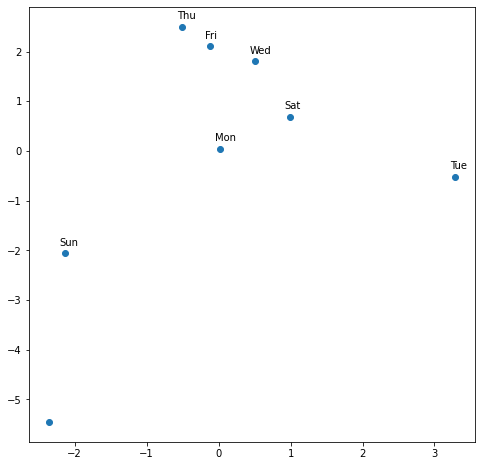

In [120]:
model.load_weights('bestmodel.hdf5')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

(13, 2)


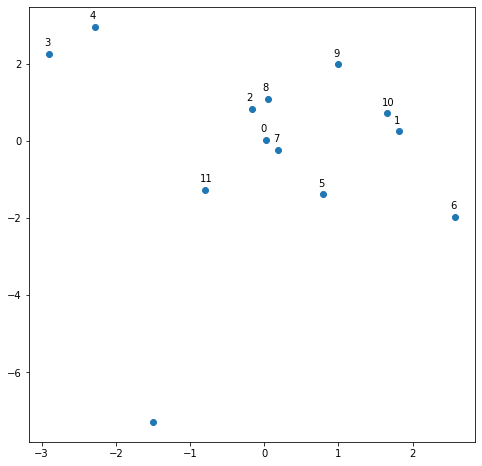

In [122]:
plot_embed('Month_Embed', list(range(12)))

In [123]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [124]:
day_of_week_embedding = model.get_layer('DayOfWeek_Embed').get_weights()[0]
day_of_week_embedding.shape

(8, 2)

/home/j3nnn1/anaconda3/envs/roosmanProject/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


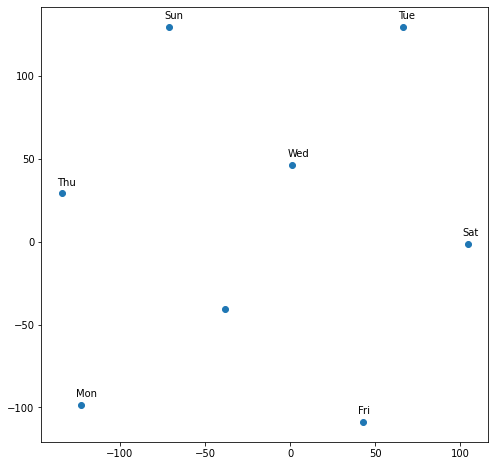

In [125]:
tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
Y = tsne.fit_transform(day_of_week_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [126]:
cat_vars

['Store', 'DayOfWeek', 'Month']

## Store embeddings

In [127]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [129]:
submodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Store_Embed (Embedding)         (None, 1, 50)        55800       Store_input[0][0]                
____________________________________________________________________________________________

In [130]:
submodel.save('embeddings_model.hdf5')